## Import

In [56]:
import pandas as pd
import os

artists = pd.read_json("data_v2/artists.jsonl", lines=True)
sessions = pd.read_json("data_v2/sessions.jsonl", lines=True)
track_storage = pd.read_json("data_v2/track_storage.jsonl", lines=True)
tracks = pd.read_json("data_v2/tracks.jsonl", lines=True)
users = pd.read_json("data_v2/users.jsonl", lines=True)

pd.set_option('mode.chained_assignment', None)

In [57]:
def get_week(date):
  return date.week

merged = sessions.merge(tracks[['id', 'id_artist', 'duration_ms']], left_on='track_id', right_on='id', how='left')
merged = merged.merge(artists[['id', 'name']], left_on='id_artist', right_on='id', how='left')

### Uwaga

Musimy pomijać ostatni tydzień, gdyż jest on niekompletny i dane z tego tygodnia są silnie zubożone.

In [58]:
data = merged[merged['timestamp'] < '2023-04-10']

data['weeks_ordered'] = merged['timestamp'].apply(get_week)

In [59]:
max_week = data['weeks_ordered'].max()
min_week = data['weeks_ordered'].min()

print(f"Min: {min_week}, Max: {max_week}")

Min: 2, Max: 14


## Get all artists and consistent artists

In [60]:
all_artists = data['name'].unique()
print(len(all_artists))

808


In [61]:
consistent_artists = []

for artist in all_artists:
    if len(data[data['name'] == artist]['weeks_ordered'].unique()) == 12:
        consistent_artists.append(artist)

print(len(consistent_artists))

199


In [62]:
def approximate_playtime(artist_sessions):
    play_playtime = artist_sessions[artist_sessions['event_type'] == 'PLAY'].groupby('weeks_ordered')['duration_ms'].sum() * 1.66e-5 # convert to minutes
    # skip_playtime = artist_sessions[artist_sessions['event_type'] == 'SKIP'].groupby('weeks_ordered')['duration_ms'].sum() / 2
    return play_playtime

In [63]:
artists_dic = {}
for artist in consistent_artists:
  artists_dic[artist] = approximate_playtime(data[data['name'] == artist])

# MODEL NAIWNY

Proponowany model naiwny będzie prostym modelem liniowym.

In [64]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [65]:
class LinearRegressionModel:
    def __init__(self):
        self._model = LinearRegression()
    
    def fit(self, x, y):
        self._model.fit(x, y)
    
    def predict(self, x):
        return self._model.predict(np.array(x).reshape((-1, 1)))

## Rysowanie predykcji i szeregów

In [66]:
def plot_naive(artist, sequence, future_points=5):
    input, label = list(sequence)[:-1], list(sequence)[-1]
    input_x = np.array([i for i in range(0, len(input))]).reshape((-1, 1))
    input_y = np.array(input)

    model = LinearRegressionModel()
    model.fit(input_x, input_y)
    predictions = pd.Series(model.predict(x) for x in range(0, len(input) + future_points))
    
    plt.figure(figsize=(15,8))
    plt.locator_params(axis='y', nbins=20)
    plt.title(f"Artist: {artist}")
    plt.xlabel("Week [ordered Number]")
    plt.ylabel("Play time [minutes]")
    # Past and current
    plt.plot(input, label="Actual data", marker='o')
    # Naive prediction
    plt.plot(predictions, label="Naive prediction", marker='o')
    # Future
    plt.plot([len(input) - 1, len(input)], [input_y[-1], label], label="Future", marker='o')
    plt.grid()
    plt.legend()


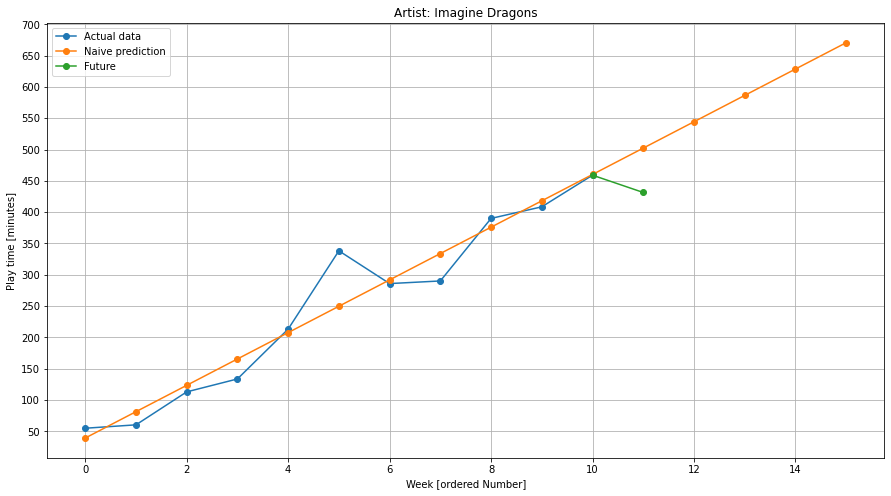

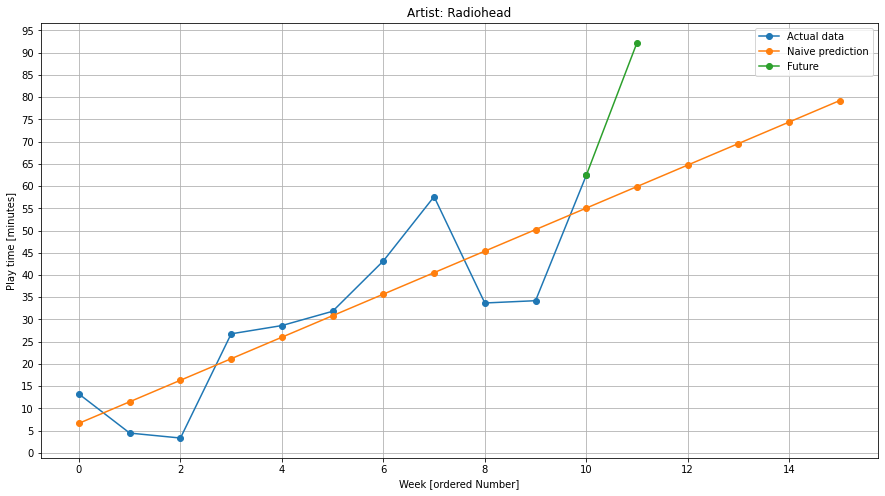

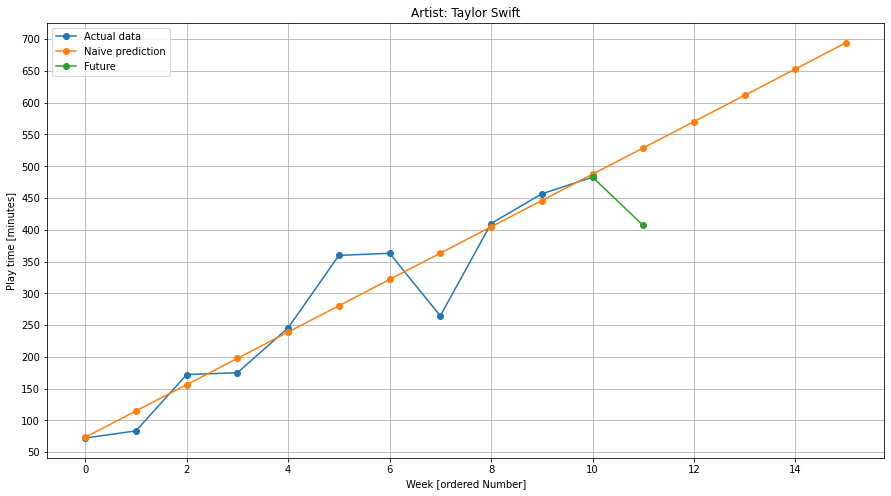

In [72]:
artists_to_display = ['Imagine Dragons', 'Radiohead', 'Taylor Swift']

for artist in artists_to_display:
  plot_naive(artist, artists_dic[artist])

## Ewaluacja modelu

Ewaluacja modelu będzie odbywała się na podstawie miary MSE.

In [68]:
def MSE(x, y):
    mse = (np.square(x - y)).mean(axis=-1)
    return mse

In [69]:
predictions, ground_truth = [], []

for artist, eval_data in artists_dic.items():
    input, label = list(eval_data)[:-1], list(eval_data)[-1]
    input_x = np.array([i for i in range(0, len(input))]).reshape((-1, 1))
    input_y = np.array(input)

    model = LinearRegressionModel()
    model.fit(input_x, input_y)

    predictions.append(model.predict(len(input)).squeeze(axis=0))
    ground_truth.append(label)

In [70]:
print(f"MSE: {MSE(np.array(predictions), np.array(ground_truth))}")

MSE: 1669.4069131874119


## Wnioski

Średni błąd kwadratowy na całym zbiorze danych artystów, dla których istnieją akcje w każdym okresie (199 artystów) wynosi 1669.4069131874119. Jest to solidna podstawa, z której można wyjść a celem powinno być stworzenie modelu o MSE conajmniej mniejszym od tego osiąganego przez model naiwny.

### Dodatkowe wnioski:

Mała liczba danych treningowych, na których można wytrenować model. Należy możliwie zwiększyć zbiór treningowy poprzez więcej danych albo zawężenie liczby okresów, na podstawie których przewidujemy średni czas słuchania w przyszłości.